In [182]:
from abc import ABC, abstractmethod
from dataclasses import dataclass
from math import exp
from math import sqrt
import matplotlib.pyplot as plt

@dataclass
class Model:
  rente:float
  volatiliteit:float
  looptijd:float 
  aantal_intervallen:int
  strike: float
  payoffType: str 
  bariere: list

  @property
  def delta_t(self)->float:
    return self.looptijd/self.aantal_intervallen
  
  @property
  def delta_x(self):
    return self.volatiliteit*sqrt(self.delta_t)
 
  @property
  def kansBoven(self):
    return (exp(self.rente * self.delta_t)-exp(-self.delta_x))/(exp(self.delta_x)-exp(-self.delta_x))
  
  @property
  def kansOnder(self):
    return 1-self.kansBoven 
  
  def payoffOptie(self, S:float):
    if self.payoffType == "call":
      return max(S-self.strike,0)
    elif self.payoffType == "put":
      return max(self.strike-S,0)
    else:
      print("error type payoff bestaat niet")
 

# schets van de oplossing
## programma 1
2 dictionaries = $V_{t}$ en $V_{t+1}$
Vt wordt uit Vt1 uit gerekend 
Vt vervangt Vt1
of mss met klassen
## programma 2
loop over alle paden (hou pad in memory)
en bereken de gemiddelde waarde met de payoff+(verdisconteren)
## programma 3
loop over willekeurige paden (hou pad in memory)
en bereken de gemiddelde waarde met de payoff+(verdisconteren)

## bijvraag
### programma 1
ik ben nu naar in binomiaal boom aan het kijken met 2 stappen
(pas de randwaarde aan) dan is de waarde van optie gekent voor alles
op eindtijdstip door de payoff en alles voorbij de bariere. 
### programma 2 en 3
schrijf een functie die uitmaakt dat pad voorbij de bariere is geweest
en pas de payoff daar op aan.

In [268]:
# test model
testModel = Model(
    rente = 0.05,
    volatiliteit= 0.15,
    looptijd= 1,
    aantal_intervallen= 10,
    strike= 0.05,
    payoffType= "call",
    bariere = [-0.2,0.2]
)

# implementatie programma 1

In [52]:
def x_waarden_op_het_einde(par:Model):
    # laagste x = -aantal_intervallen * delta_x
    laagste_x = -par.aantal_intervallen * par.delta_x 
    aantal_x_waarde_einde = par.aantal_intervallen+1
    return [laagste_x + 2*par.delta_x *i for i in range(aantal_x_waarde_einde)]

def init_V(par:Model):
    return {x:par.payoffOptie(x) for x in x_waarden_op_het_einde(par)}

def plot_V(V):
    x,y = zip(*V.items())
    plt.plot(x,y)
    plt.show()

# TODO: dit kan beter met een dictionary comprehension
def terug_V(V,par:Model):
    Vterug = {}
    for i in range(len(V.keys())-1):
        keys = list(V.keys())
        x = keys[i]
        x_volg = keys[i+1]
        x_nieuw  = (x+x_volg)/2
        V_nieuw = V[x]*par.kansOnder + V[x_volg] * par.kansBoven
        Vterug[x_nieuw] = V_nieuw * exp(-par.rente * par.delta_t) 
    return Vterug

def eindigeDifferentie(par:Model):
    V = init_V(par)
    for _ in range(par.aantal_intervallen):
        V = terug_V(V,par)
    return V

In [53]:
print(x_waarden_op_het_einde(testModel))

[-0.4743416490252569, -0.3794733192202055, -0.2846049894151541, -0.18973665961010278, -0.09486832980505139, 0.0, 0.09486832980505133, 0.18973665961010278, 0.2846049894151541, 0.37947331922020544, 0.4743416490252569]


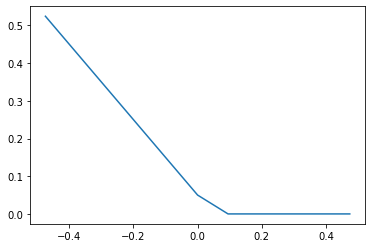

In [56]:
V = init_V(testModel)
plot_V(V)

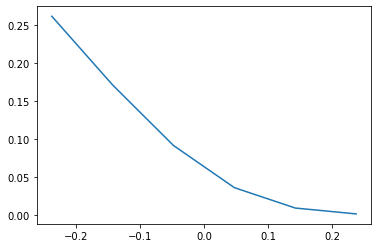

In [57]:
V = init_V(testModel)
for _ in range(testModel.aantal_intervallen // 2):
    V = terug_V(V,testModel)
plot_V(V)

In [58]:
eindigeDifferentie(testModel)

{-1.3877787807814457e-17: 0.06358034707513392}

# implementatie programma 2

In [59]:
from collections import namedtuple
Pad = namedtuple("Pad",["weg","stappen_op", "stappen_neer"])
#TODO maak dit beter want dit is niet leesbaar
def padGenA(n,d):
    if n==0:
        yield Pad([0],0,0) 
    else: 
        for g in padGenA(n-1,d):
            weg = g.weg + [g.weg[-1] -d]
            yield Pad(weg,g.stappen_op, g.stappen_neer +1)
        for g in padGenA(n-1,d):
            weg = g.weg + [g.weg[-1] +d]
            yield Pad(weg,g.stappen_op+1, g.stappen_neer )

def padGen(par:Model):
    if par.aantal_intervallen > 10:
        raise Exception("te veel paden niet over loopen pas op voor crash")
    else:
        return padGenA(par.aantal_intervallen,par.delta_x)

Pad(weg=[0, -0.04743416490252569, 0.0, 0.04743416490252569, 0.0, 0.04743416490252569, 0.0, -0.04743416490252569, 0.0, -0.04743416490252569, -0.09486832980505137], stappen_op=4, stappen_neer=6)


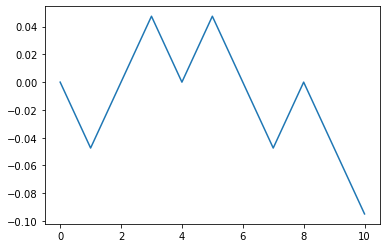

In [68]:
g = padGen(testModel)
for _ in range(150):
    next(g)
p = next(g)
print(p)
plt.plot(range(11),p.weg)
plt.show()

In [96]:
def somOverAllePaden(par:Model):
    return sum(par.payoffOptie(pad.weg[-1]) * par.kansBoven**(pad.stappen_op) * par.kansOnder**(pad.stappen_neer) \
        for pad in padGen(par)) * exp(-par.rente*par.looptijd)


In [67]:
somOverAllePaden(testModel)

0.06358034707513391

# implementatie programma 3 (importance sampling achtig)

In [113]:
from random import randint
#TODO maak dit beter want dit is niet leesbaar
def padGenARandom(n,d,aantal_paden):
    if n==0:
        yield Pad([0],0,0) 
    else: 
        for _ in range(aantal_paden):
            for g in padGenARandom(n-1,d,1):
                if randint(0,1):
                    weg = g.weg + [g.weg[-1] -d]
                    yield Pad(weg,g.stappen_op, g.stappen_neer +1)
                else:
                    weg = g.weg + [g.weg[-1] +d]
                    yield Pad(weg,g.stappen_op+1, g.stappen_neer )
                    

def padGenRandomUniform(par:Model,n:"aantal_paden"):
    return padGenARandom(par.aantal_intervallen,par.delta_x,n)

Pad(weg=[0, 0.04743416490252569, 0.0, 0.04743416490252569, 0.0, -0.04743416490252569, 0.0, 0.04743416490252569, 0.0, -0.04743416490252569, 0.0], stappen_op=5, stappen_neer=5)


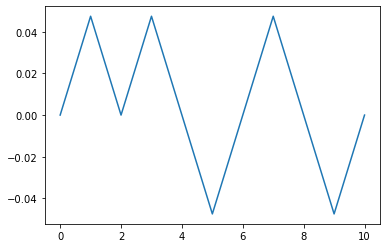

In [114]:
g = padGenRandomUniform(testModel,1)
p = next(g)
print(p)
plt.plot(range(11),p.weg)
plt.show()

In [125]:
def monteCarloUniform(par:Model, n:"aantalpaden"):
    return sum(par.payoffOptie(pad.weg[-1]) * par.kansBoven**(pad.stappen_op) * par.kansOnder**(pad.stappen_neer) \
        for pad in padGenRandomUniform(par,n)) * exp(-par.rente*par.looptijd)* 2 **(par.aantal_intervallen)/n

In [181]:
monteCarloUniform(testModel,1000)

0.061848283244060866

# implementatie programma 3 (zoals in de opgave)

In [141]:
from random import random
#TODO maak dit beter want dit is niet leesbaar
def padGenBRandom(n,d,aantal_paden,kansBoven):
    if n==0:
        yield Pad([0],0,0) 
    else: 
        for _ in range(aantal_paden):
            for g in padGenBRandom(n-1,d,1,kansBoven):
                if random()>kansBoven:
                    weg = g.weg + [g.weg[-1] -d]
                    yield Pad(weg,g.stappen_op, g.stappen_neer +1)
                else:
                    weg = g.weg + [g.weg[-1] +d]
                    yield Pad(weg,g.stappen_op+1, g.stappen_neer )
                    

def padGenRandomRiskFree(par:Model,n:"aantal_paden"):
    return padGenBRandom(par.aantal_intervallen,par.delta_x,n,par.kansBoven)

In [143]:
def monteCarloRiskFree(par:Model, n:"aantalpaden"):
    return sum(par.payoffOptie(pad.weg[-1]) \
        for pad in padGenRandomRiskFree(par,n)) * exp(-par.rente*par.looptijd)/n

In [169]:
monteCarloRiskFree(testModel,1000)

0.06789796524987109

# bijvraag 

wat ik in programma 1 aanpas is gewoon alles voor bij de bariere

In [266]:

def init_V_bar(par:Model):
    return {x:par.payoffOptie(x) if par.bariere[0]<x<par.bariere[1] else 0 for x in x_waarden_op_het_einde(par) }

def plot_V(V):
    x,y = zip(*V.items())
    plt.plot(x,y)
    plt.show()

# TODO: dit kan beter met een dictionary comprehension
def terug_V_bar(V,par:Model):
    Vterug = {}
    for i in range(len(V.keys())-1):
        keys = list(V.keys())
        x = keys[i]
        x_volg = keys[i+1]
        x_nieuw  = (x+x_volg)/2
        V_nieuw = V[x]*par.kansOnder + V[x_volg] * par.kansBoven if par.bariere[0]<x_nieuw<par.bariere[1] else 0  
        Vterug[x_nieuw] = V_nieuw * exp(-par.rente * par.delta_t) 
    return Vterug

def eindigeDifferentie_bar(par:Model):
    V = init_V_bar(par)
    for _ in range(par.aantal_intervallen):
        V = terug_V_bar(V,par)
    return V

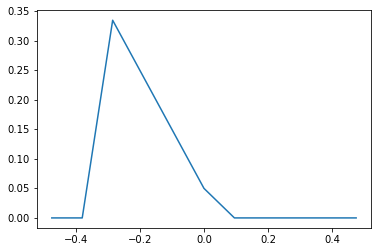

In [190]:
V = init_V_bar(testModel)
plot_V(V)

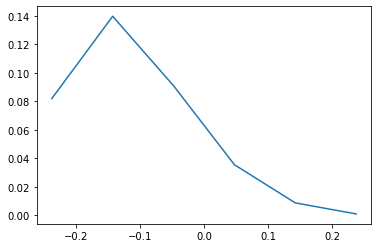

In [192]:
V = init_V_bar(testModel)
for _ in range(testModel.aantal_intervallen // 2):
    V = terug_V_bar(V,testModel)
plot_V(V)

programma 2 en 3 doe ik samen ik verwijder gewoon de bedragen van alle wegen die over
de bariere zijn geweest, ik schrijf een functie die checkt dat een weg over de bariere is geweest (zeker niet op de meest efficienste manier maar er zijn al zoveel inefiecienties ...)

In [231]:
def binnenBariere(p:Pad,par:Model):
    return bool(min(par.bariere[0]<x<par.bariere[1] for x in p.weg))

[-0.2, 0.2]
Pad(weg=[0, -0.04743416490252569, 0.0, -0.04743416490252569, 0.0, 0.04743416490252569, 0.0, 0.04743416490252569, 0.09486832980505137, 0.04743416490252569, 0.0], stappen_op=5, stappen_neer=5)
True


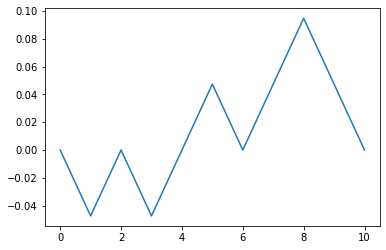

In [250]:
print(testModel.bariere)
g = padGenRandomUniform(testModel,1)
p = next(g)
print(p)
print(binnenBariere(p,testModel))
plt.plot(range(11),p.weg)
plt.show()

In [254]:
def monteCarloUniform_bar(par:Model, n:"aantalpaden"):
    return sum(par.payoffOptie(pad.weg[-1]) * par.kansBoven**(pad.stappen_op) * par.kansOnder**(pad.stappen_neer) \
        for pad in padGenRandomUniform(par,n) if binnenBariere(pad,par)) * exp(-par.rente*par.looptijd)* 2 **(par.aantal_intervallen)/n

def somOverAllePaden_bar(par:Model):
    return sum(par.payoffOptie(pad.weg[-1]) * par.kansBoven**(pad.stappen_op) * par.kansOnder**(pad.stappen_neer) \
        for pad in padGen(par) if binnenBariere(pad,par)) * exp(-par.rente*par.looptijd)

def monteCarloRiskFree_bar(par:Model, n:"aantalpaden"):
    return sum(par.payoffOptie(pad.weg[-1]) \
        for pad in padGenRandomRiskFree(par,n) if binnenBariere(pad,par)) * exp(-par.rente*par.looptijd)/n

In [269]:
print(monteCarloRiskFree_bar(testModel,1000))
print(somOverAllePaden_bar(testModel))
print(monteCarloUniform_bar(testModel,1000))
print(eindigeDifferentie_bar(testModel))

0.021442804172524005
0.022571080359800048
0.021262741792688916
{-1.3877787807814457e-17: 0.02257108035979997}
